# Autoencoder and Variational Autoencoder
## 使用VAE來做手寫辨識

### 初始安裝

In [54]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils
from keras import backend as K

env: KERAS_BACKEND=tensorflow


### 匯入MNIST資料庫

In [55]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)      #調整資料長相及單位化
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


接下來把activation改成relu，並將loss function改為binary_crossentropy

In [66]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()
x = Input(shape=(784,))

enc_1 = Dense(200, activation='relu')
enc_2 = Dense(2, activation='relu')

h = enc_2(enc_1(x))

dec_2 = Dense(200, activation='relu')
dec_1 = Dense(784, activation='relu')

x_hat = dec_1(dec_2(h))

autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 402       
_________________________________________________________________
dense_44 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_45 (Dense)             (None, 784)               157584    
Total params: 315,586
Trainable params: 315,586
Non-trainable params: 0
_________________________________________________________________


In [67]:
autoencoder.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy'])
autoencoder.fit(x_train, x_train, batch_size=100, epochs=20)
#autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

Epoch 1/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.9560 - acc: 0.8016
Epoch 2/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.8800 - acc: 0.8003
Epoch 3/20
60000/60000 [==============================] - 5s 76us/step - loss: 0.8430 - acc: 0.8003
Epoch 4/20
60000/60000 [==============================] - 5s 76us/step - loss: 0.7924 - acc: 0.8005
Epoch 5/20
60000/60000 [==============================] - 5s 76us/step - loss: 0.7482 - acc: 0.8000
Epoch 6/20
60000/60000 [==============================] - 5s 76us/step - loss: 0.7381 - acc: 0.7999
Epoch 7/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.7190 - acc: 0.7994
Epoch 8/20
60000/60000 [==============================] - 5s 84us/step - loss: 0.7115 - acc: 0.8000
Epoch 9/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.7049 - acc: 0.8005
Epoch 10/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.6985 - acc: 0.8001

### 視覺化

In [68]:
Encoder = Model(x, h)
Encoder.summary()
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 402       
Total params: 157,402
Trainable params: 157,402
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 200)               600       
_________________________________________________________________
dens

### Encoder的視覺化

第 7317 圖的 latent 表示為 [[0. 0.]]


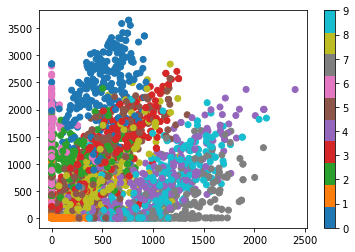

In [69]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))
indices = np.random.randint(x_test.shape[0], size=3000)
latents = Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

### Decoder的視覺化

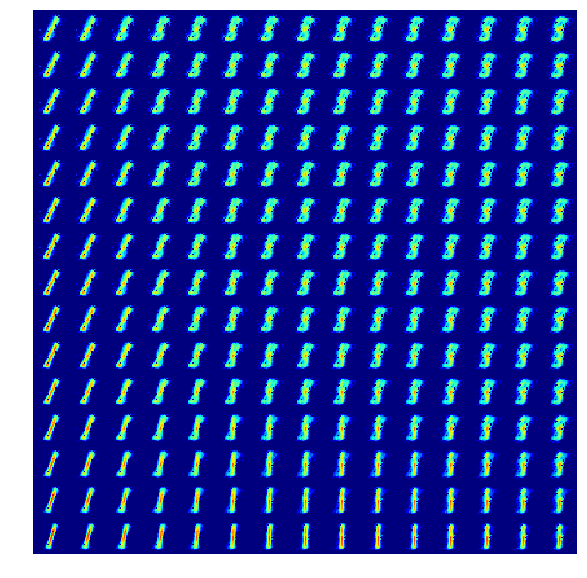

In [70]:
n = 15        #均勻取樣 $15*15$ 個點，透過 Decoder 進行圖片的還原。
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
       
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='jet')
plt.axis('off')
plt.show()

## Variational Autoencoder (VAE)

In [71]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)


#定義抽樣函數
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
dec_x = dec_2(z)
x_hat = dec_1(dec_x)
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 100)          78500       input_17[0][0]                   
__________________________________________________________________________________________________
dense_47 (Dense)                (None, 2)            202         dense_46[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 2)            202         dense_46[0][0]                   
__________________________________________________________________________________________________
lambda_2 (

### 建立 loss 函數

In [72]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

### 訓練 VAE

In [74]:
VAE.compile(loss=vae_loss, optimizer=Adam(),metrics=['accuracy'])
VAE.fit(x_train, x_train, batch_size=128, epochs=20)
VAE.load_weights('VAE_handwriting_model_weights.h5')

Epoch 1/20
60000/60000 [==============================] - 5s 77us/step - loss: 180.5659 - acc: 0.0125
Epoch 2/20
60000/60000 [==============================] - 3s 56us/step - loss: 179.8358 - acc: 0.0125
Epoch 3/20
60000/60000 [==============================] - 4s 59us/step - loss: 178.9500 - acc: 0.0122
Epoch 4/20
60000/60000 [==============================] - 4s 62us/step - loss: 178.0959 - acc: 0.0126
Epoch 5/20
60000/60000 [==============================] - 4s 61us/step - loss: 177.0001 - acc: 0.0130
Epoch 6/20
60000/60000 [==============================] - 3s 57us/step - loss: 176.0840 - acc: 0.0135
Epoch 7/20
60000/60000 [==============================] - 3s 57us/step - loss: 175.1642 - acc: 0.0136
Epoch 8/20
60000/60000 [==============================] - 4s 62us/step - loss: 174.1576 - acc: 0.0135
Epoch 9/20
60000/60000 [==============================] - 4s 61us/step - loss: 173.3672 - acc: 0.0143
Epoch 10/20
60000/60000 [==============================] - 4s 60us/step - loss: 17

VAE訓練出來的accuracy好低啊QQ

### Encoder的視覺化

In [28]:
#Encoder
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [75]:
#Decoder
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_50 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


第 49709 圖的 latent 表示為 [[-1.3857495  2.1984525]]


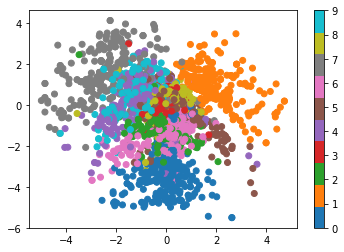

In [76]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))
VAE_latents = VAE_Encoder.predict(x_test[indices])
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab10')
plt.colorbar()
plt.show()

### Decoder的視覺化

In [77]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

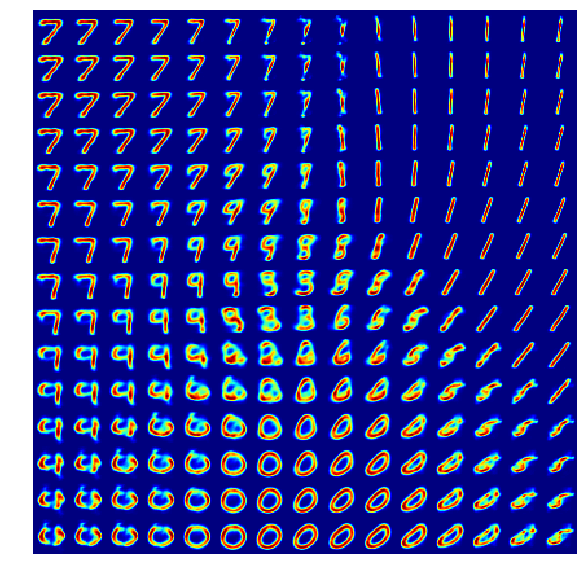

In [78]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='jet')
plt.axis('off')
plt.show()


## 動態互動

In [80]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(15, 7))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='jet')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

    
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>